### Standford Cars Vehicle Recognition - ResNet50 w/ fastai

### Due to computation limitations, the notebook kernel was restarted after each training phase (a lot of RAM and kernel errors/crashes). Models trained were saved and loaded back to continue the training. The saved outputs are attached via Ipython.display.Image function.

### CODE ONLY, For a detailed report, please refer to the Final Report

#### by Sean Sungil Kim

In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from glob import iglob
from IPython.core.display import Image, display
import cv2
import time

# custom python scripts
import SC_sungil             # preprocessing

In [3]:
#SC_sungil.test_to_train(22)
#SC_sungil.from_fold_und_smpl_reset()
#SC_sungil.from_fold_und_smpl()

data_dir = '/home/ec2-user/stanford-car-dataset-by-classes-folder/car_data/car_data/und/'
data_path = Path(data_dir)

img_data_list = os.listdir(data_dir + 'train')
class_num = len(img_data_list)
print('There are total %i classes in the Vehicle-detected Stanford Cars Dataset' % (class_num))

There are total 189 classes in the Vehicle-detected Stanford Cars Dataset


In [4]:
x_tot = np.zeros(3)
x2_tot = np.zeros(3)
cnt = 0

for img_path in iglob(data_dir + 'train/*/*.jpg'):
    imagearray = cv2.imread(img_path).reshape(-1,3)/255.
    x_tot += imagearray.mean(axis = 0)
    x2_tot += (imagearray**2).mean(axis=0)
    cnt += 1
    
channel_avr = x_tot/cnt
channel_std = np.sqrt(x2_tot/cnt - channel_avr**2)
channel_avr, channel_std

(array([0.403171, 0.401802, 0.422073]), array([0.291696, 0.287418, 0.291519]))

In [5]:
data = ImageDataBunch.from_folder(data_path, train = 'train', valid = 'test', test = 'additional_images',\
            ds_tfms = get_transforms(do_flip = True, flip_vert = False, max_rotate = 90),\
                size = 224, resize_method = ResizeMethod.SQUISH, bs = 64, num_workers = 0)\
                .normalize([tensor(channel_avr.tolist()), tensor(channel_std.tolist())])

data_test = ImageDataBunch.from_folder(data_path, train = 'train', valid = 'additional_images',\
            ds_tfms = get_transforms(do_flip = True, flip_vert = False, max_rotate = 90),\
                size = 224, resize_method = ResizeMethod.SQUISH, bs = 64, num_workers = 0)\
                .normalize([tensor(channel_avr.tolist()), tensor(channel_std.tolist())])

data

ImageDataBunch;

Train: LabelList (8694 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Acura Integra Type R,Acura Integra Type R,Acura Integra Type R,Acura Integra Type R,Acura Integra Type R
Path: /home/ec2-user/stanford-car-dataset-by-classes-folder/car_data/car_data/und;

Valid: LabelList (3883 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Acura Integra Type R,Acura Integra Type R,Acura Integra Type R,Acura Integra Type R,Acura Integra Type R
Path: /home/ec2-user/stanford-car-dataset-by-classes-folder/car_data/car_data/und;

Test: LabelList (30 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/ec2-user/stanford-car-dataset-by-classes-folder/car_data/car_data/und

In [6]:
data_test

ImageDataBunch;

Train: LabelList (8694 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Acura Integra Type R,Acura Integra Type R,Acura Integra Type R,Acura Integra Type R,Acura Integra Type R
Path: /home/ec2-user/stanford-car-dataset-by-classes-folder/car_data/car_data/und;

Valid: LabelList (30 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Acura RL Sedan,Acura TL Sedan,AM General Hummer SUV,Aston Martin V8 Vantage Convertible,Aston Martin Virage Convertible
Path: /home/ec2-user/stanford-car-dataset-by-classes-folder/car_data/car_data/und;

Test: None

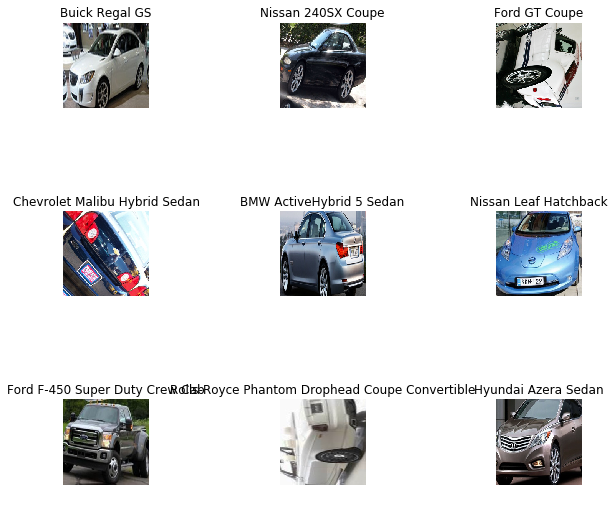

In [7]:
# preview of training data generated from ImageDataBunch
data.show_batch(rows = 3, figsize = (8, 8))

In [8]:
# first 5 class labels obtained from the class-folder names
print(data.classes[:5])

['AM General Hummer SUV', 'Acura Integra Type R', 'Acura RL Sedan', 'Acura TL Sedan', 'Acura TL Type-S']


In [9]:
# loading the pre-trained ResNet50 cnn
learn = cnn_learner(data, models.resnet50, pretrained = True, metrics = accuracy,\
                    callback_fns = ShowGraph, model_dir = "/home/ec2-user/")
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________

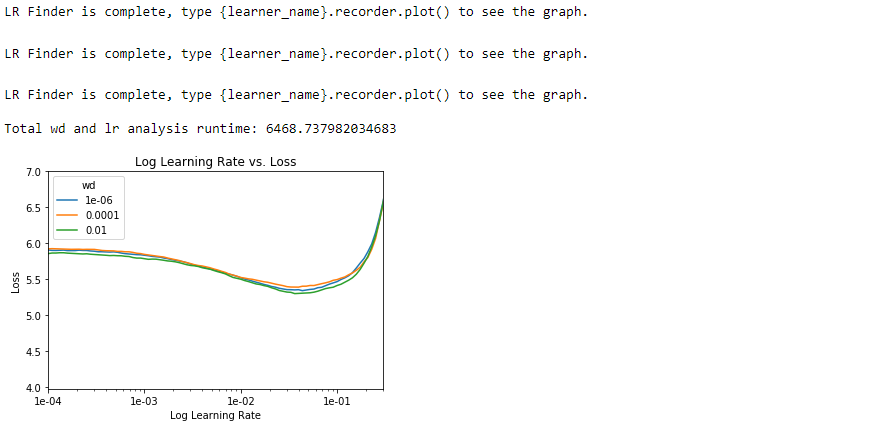

In [22]:
lr_List = []
loss_List = []
wd_List = [1e-6, 1e-4, 1e-2]

start_ts = time.time()
for wd in wd_List:
    exp_learn = cnn_learner(data, models.resnet50, pretrained = True, metrics = accuracy,\
                            model_dir = "/tmp/exp/model/")
    exp_learn.lr_find(wd = wd, num_it = 200)
    lr_List.append(exp_learn.recorder.lrs)
    loss_List.append(exp_learn.recorder.losses)

min_y = 4
max_y = 7
_, ax = plt.subplots(1, 1)
for i in range(len(loss_List)):
    ax.plot(lr_List[i], loss_List[i])
    min_y = min(np.asarray(loss_List[i]).min(), min_y)
ax.set_title('Log Learning Rate vs. Loss'), ax.set_ylabel('Loss'), ax.set_xlabel('Log Learning Rate')
ax.set_xscale('log'), ax.set_xlim((1e-4,3e-1)), ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wd_List, title = 'wd'), ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
print("\nTotal wd and lr analysis runtime:", time.time() - start_ts)
#display(Image(filename = 'outputs/ResNet50/lrfinder1.png'))

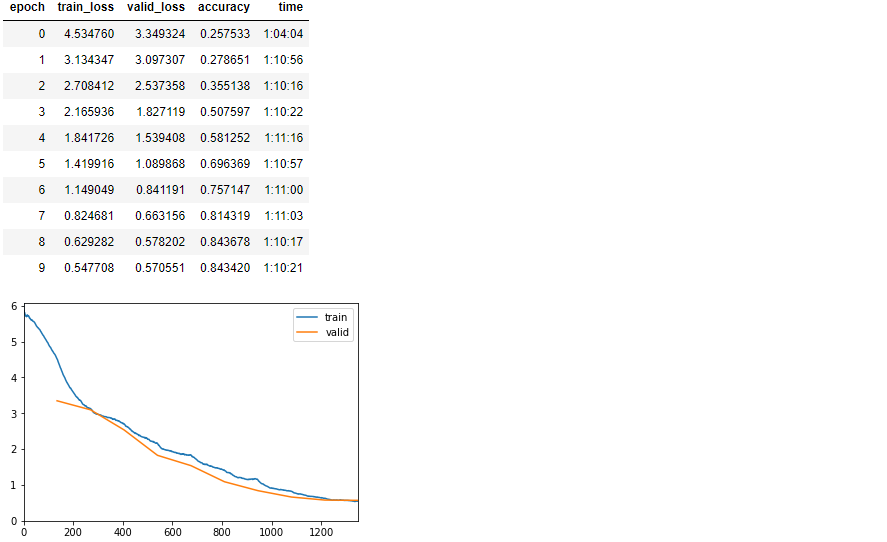

In [23]:
learn.fit_one_cycle(10, max_lr = 1e-2, wd = 1e-2)
learn.save('/home/ec2-user/ResNet50_phase1', return_path = True)
#display(Image(filename = 'outputs/ResNet50/toplayer output1.png'))

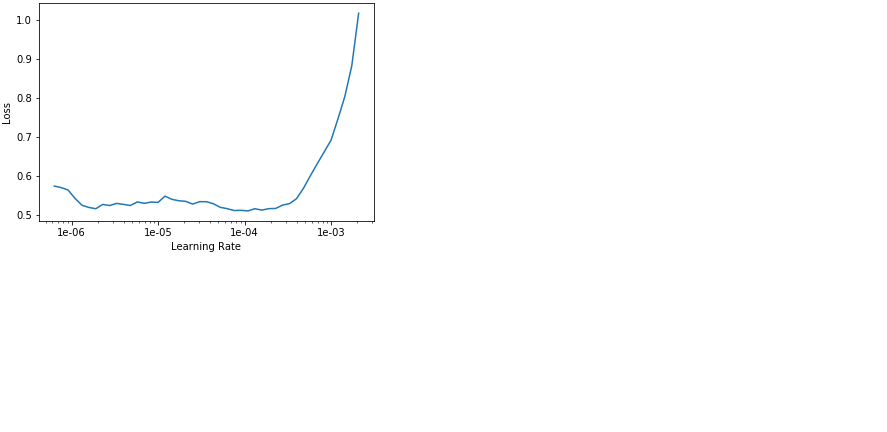

In [24]:
learn.lr_find(wd = 1e-2)
learn.recorder.plot()
#display(Image(filename = 'outputs/ResNet50/lrfinder2.png'))

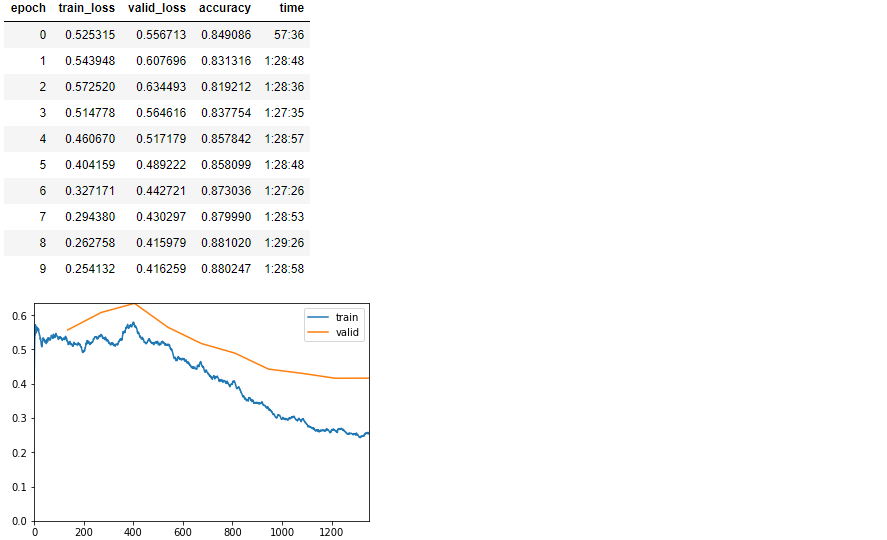

In [25]:
learn = learn.load('/home/ec2-user/ResNet50_phase2')
learn.unfreeze()
learn.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), wd = 1e-2)
learn.save('/home/ec2-user/ResNet50_phase3', return_path = True)
#display(Image(filename = 'outputs/ResNet50/hypertuned output1.png'))

In [10]:
learn1 = learn.load('/home/ec2-user/ResNet50_phase1')
val_preds1, val_targets1 = learn1.get_preds()
preds1 = val_preds1.tolist()
cls_preds1 = np.array([pred1.index(max(pred1))for pred1 in preds1])
precision1, recall1, fscore1, support1 = precision_recall_fscore_support(np.array(val_targets1), cls_preds1, average = 'weighted')
print('The precision score is', precision1, '\nThe recall score is', recall1, '\nThe fscore score is', fscore1)

The precision score is 0.8565727325978719 
The recall score is 0.8434200360545969 
The fscore score is 0.8442767408991095


In [11]:
learn2 = learn.load('/home/ec2-user/ResNet50_phase2')
val_preds2, val_targets2 = learn2.get_preds()
preds2 = val_preds2.tolist()
cls_preds2 = np.array([pred2.index(max(pred2))for pred2 in preds2])
precision2, recall2, fscore2, support2 = precision_recall_fscore_support(np.array(val_targets2), cls_preds2, average = 'weighted')
print('The precision score is', precision2, '\nThe recall score is', recall2, '\nThe fscore score is', fscore2)

The precision score is 0.891808046663706 
The recall score is 0.880247231522019 
The fscore score is 0.8815954450168534


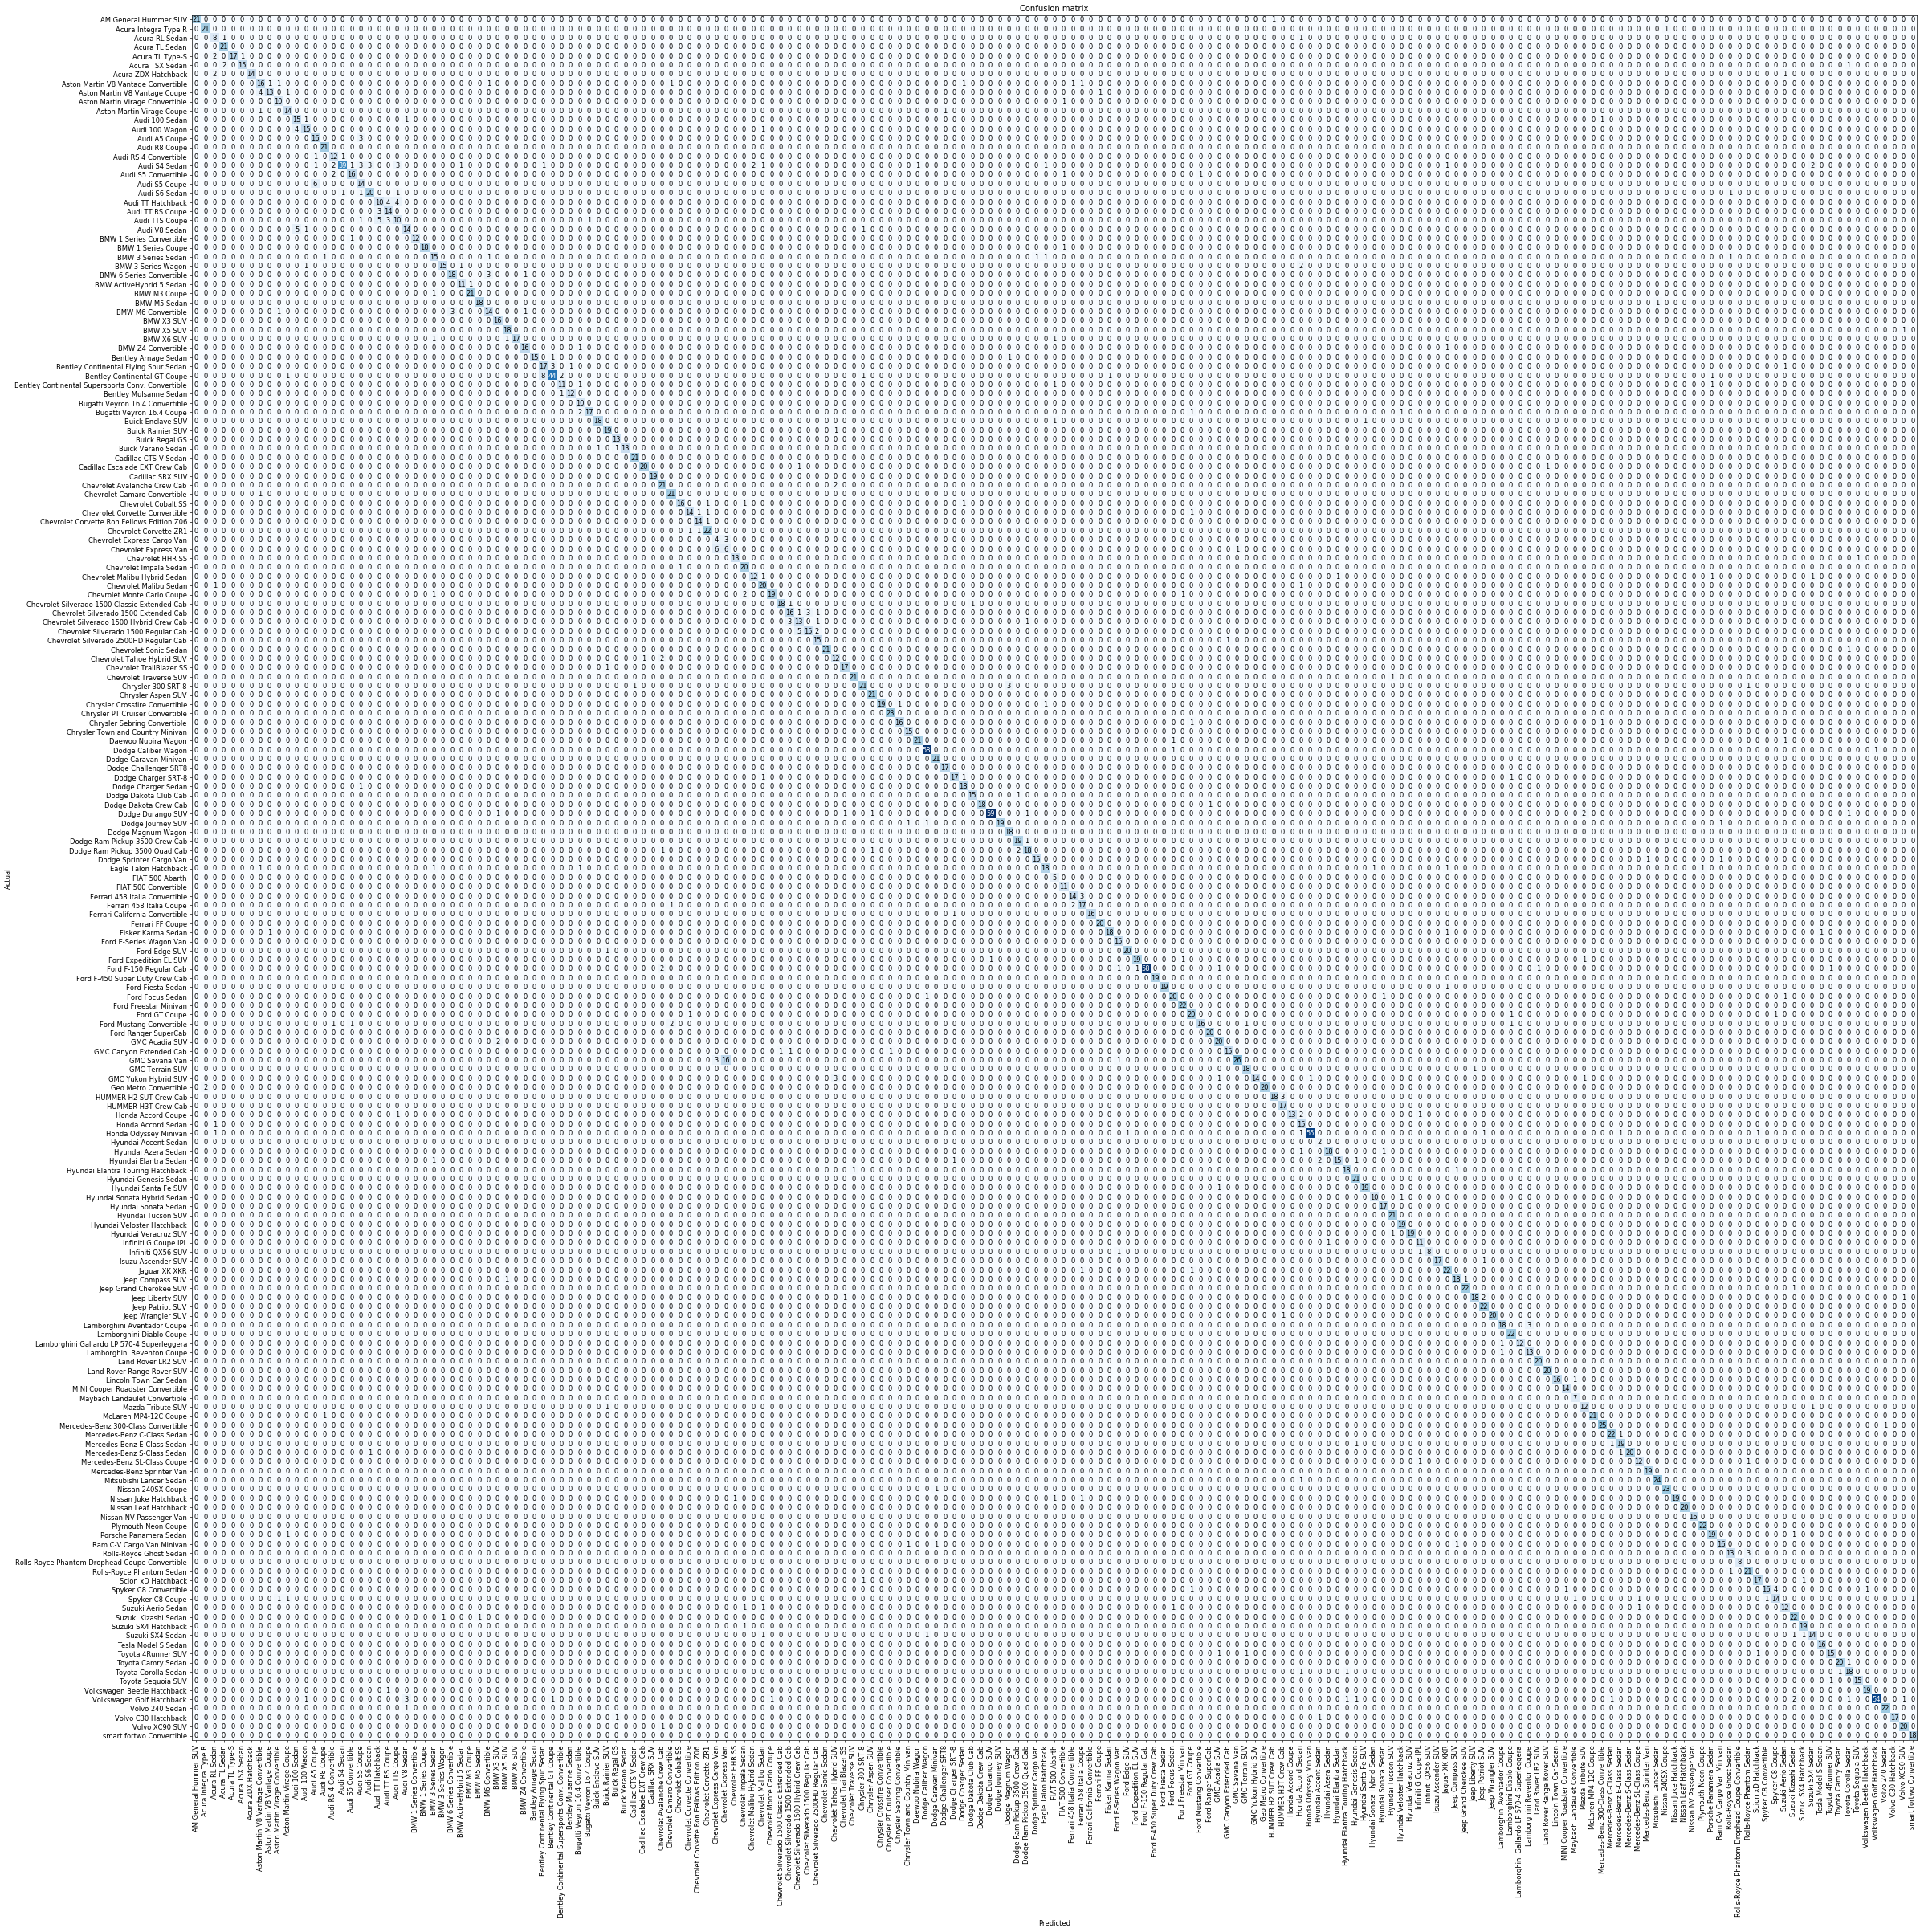

In [12]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix(figsize = (40, 40), dpi = 60)

In [13]:
# losses, idxs = interp.top_losses()
interp2.most_confused(min_val = 6)

[('GMC Savana Van', 'Chevrolet Express Van', 16),
 ('Bentley Continental GT Coupe', 'Bentley Continental Flying Spur Sedan', 8),
 ('Audi S5 Coupe', 'Audi A5 Coupe', 6),
 ('Chevrolet Express Van', 'Chevrolet Express Cargo Van', 6)]

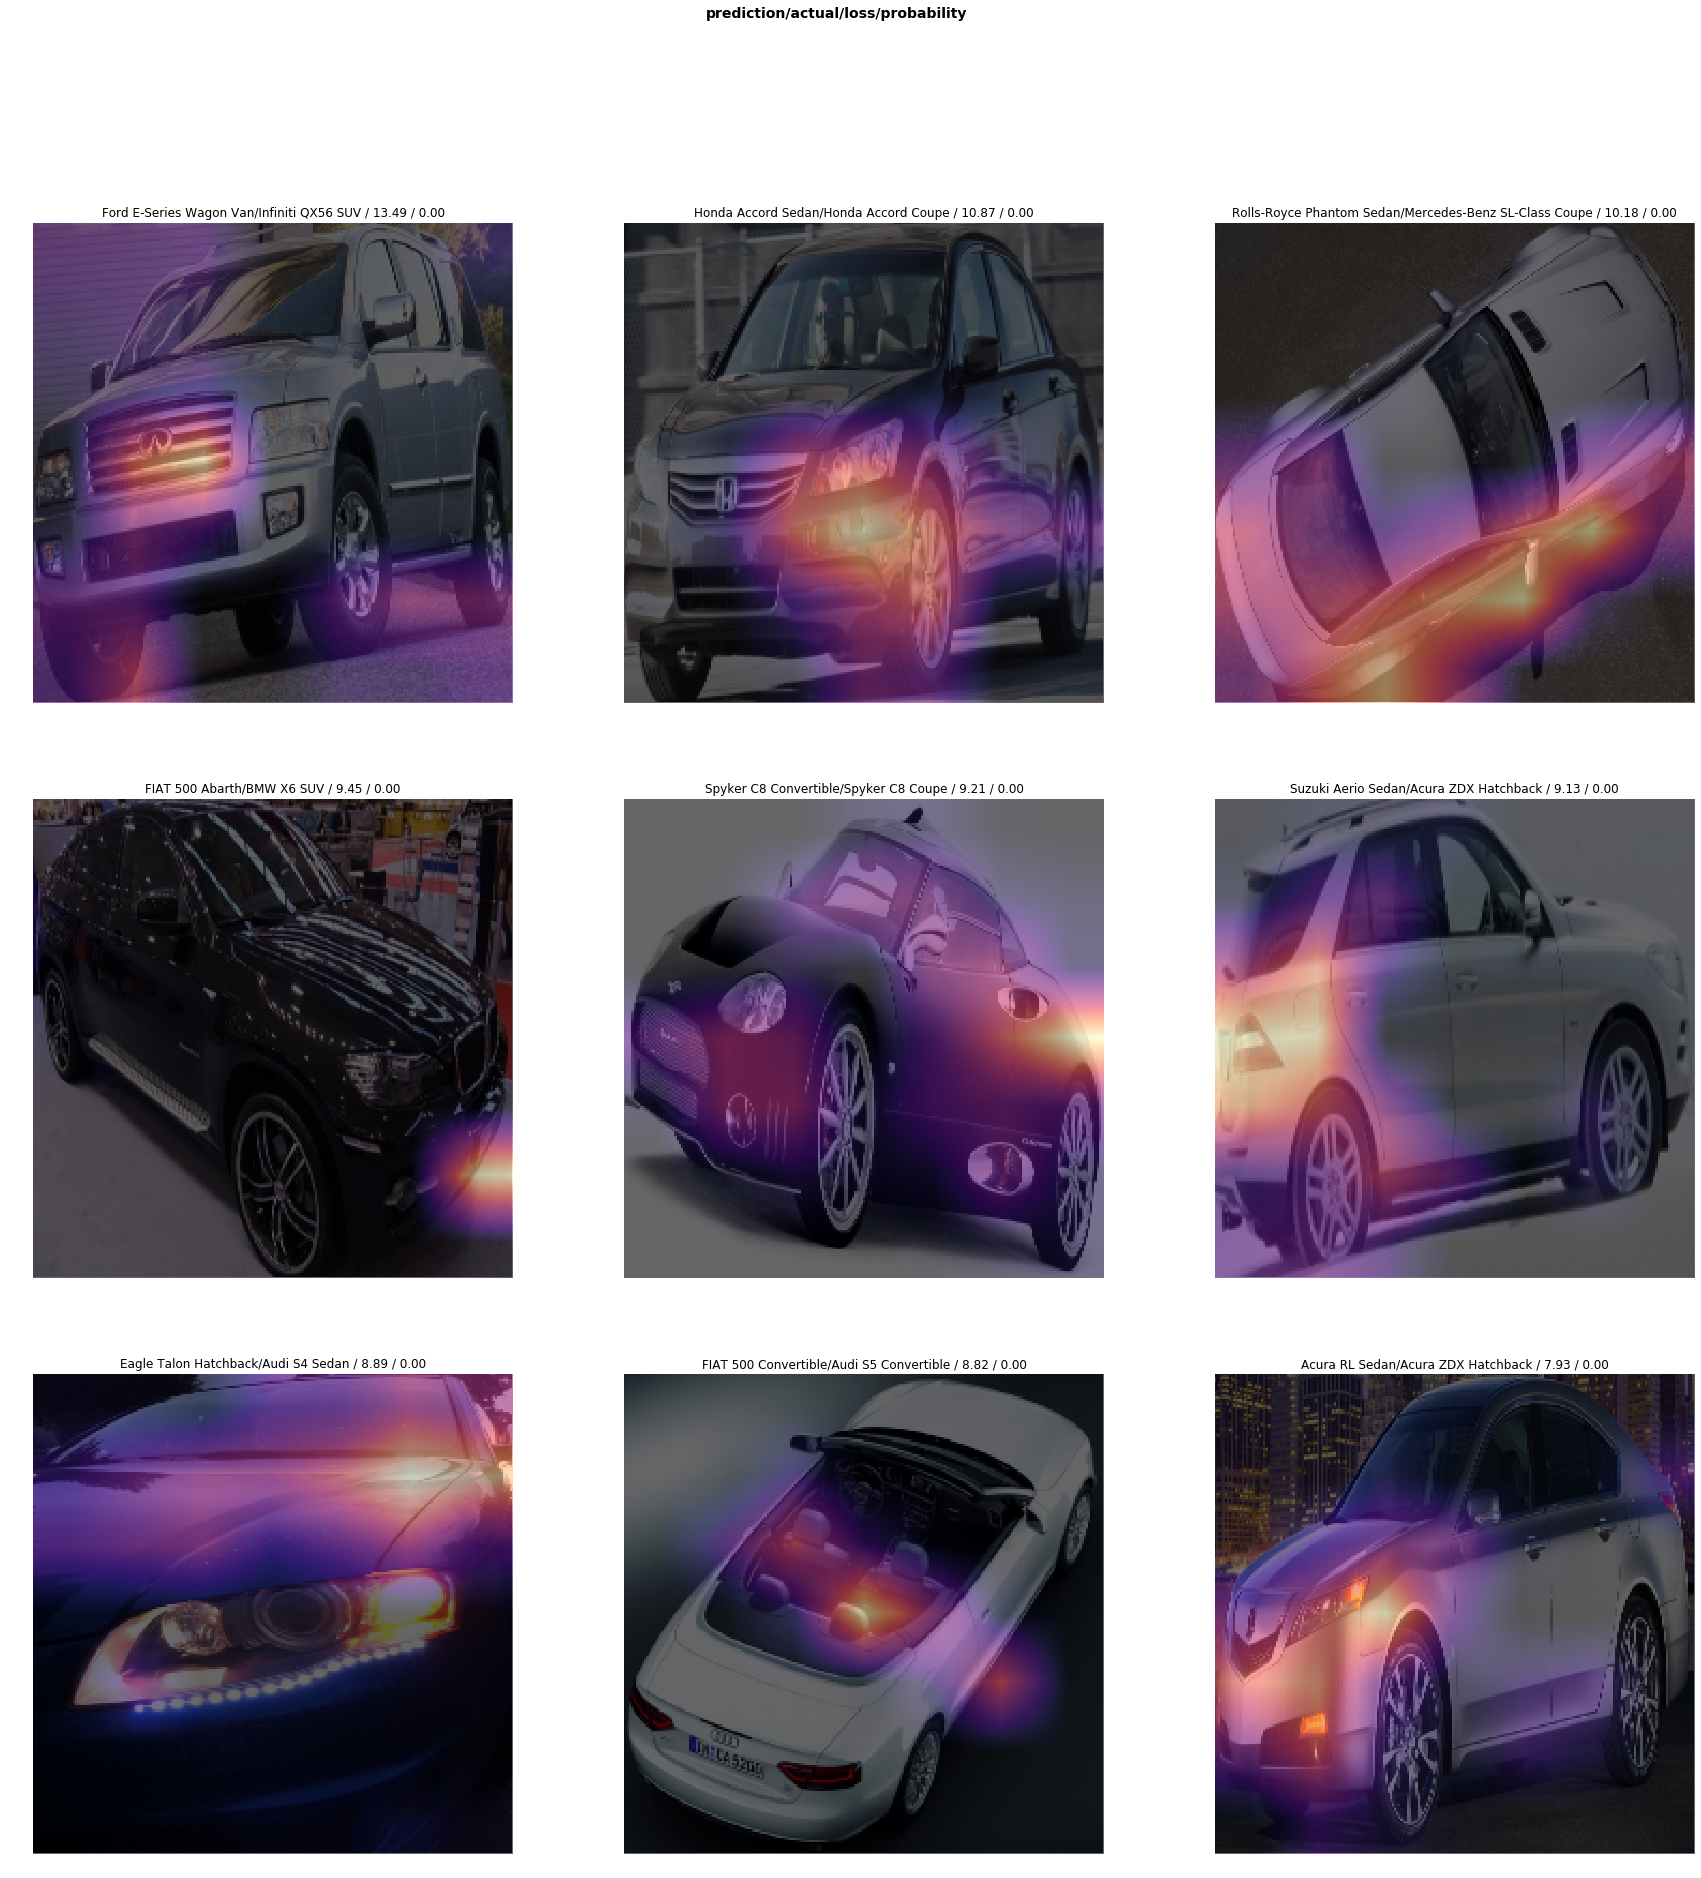

In [14]:
interp2.plot_top_losses(9, figsize = (30, 30))

In [15]:
# predicting on real world images without the detection phase
test_preds, empty_targets = learn2.get_preds(ds_type = DatasetType.Test)
test_preds_lst = test_preds.tolist()
test_cls_preds = np.array([pred.index(max(pred))for pred in test_preds_lst])

test_targets = []
for i in range(len(data_test.valid_ds.y)):
    test_targets.append(data.classes.index(str(data_test.valid_ds.y[i])))
test_targets = np.array(test_targets)

precision, recall, fscore, support = precision_recall_fscore_support(test_targets, test_cls_preds, average = 'weighted')
print('The precision score is', precision, '\nThe recall score is', recall, '\nThe fscore score is', fscore)

The precision score is 0.7333333333333333 
The recall score is 0.7333333333333333 
The fscore score is 0.7333333333333333


/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [16]:
# misclassified images
for i in range(len(test_targets)):
    if test_targets[i] != test_cls_preds[i]:
        print(data.classes[test_targets[i]], 'was misclassified as', data.classes[test_cls_preds[i]])

Audi A5 Coupe was misclassified as Chevrolet TrailBlazer SS
Audi S6 Sedan was misclassified as Mitsubishi Lancer Sedan
Dodge Challenger SRT8 was misclassified as Chevrolet Camaro Convertible
Ferrari 458 Italia Coupe was misclassified as Geo Metro Convertible
Hyundai Sonata Sedan was misclassified as Ford Fiesta Sedan
Land Rover Range Rover SUV was misclassified as Cadillac SRX SUV
Mercedes-Benz SL-Class Coupe was misclassified as BMW 1 Series Convertible
Rolls-Royce Phantom Drophead Coupe Convertible was misclassified as Rolls-Royce Phantom Sedan
